# Get 3D point cloud using Medadepth depth maps

In this notebook, we compute the 3D coordinates of pixels in GSV images using Megadepth depth maps and the pinhole camera model.  
We then choose a threshold and flood up to this height.  
Note that we do not have information in meters, so we would need to a apply a scale factor to recover the metric relative dimensions, and the offset for the absolute values wrt ground.  

Further work : to get the information of the ground level, we could segment the ground and fit a plane to the points labeled as ground. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import tan, sin, cos, pi, atan, radians, degrees
import matplotlib.pyplot as plt

import skimage
from PIL import Image
from open3d import *    

The images that we used to test this notebook are 512 * 512 pixels images fetched with the Google Street View API (used in our website), specifying a pitch of 10° and a field of view of 120°. 
In order for the watermarks on the border not to perturb the depth map inference by Megadepth, the images were center-cropped to 472 * 472 pixels. They were then resized to 512*512 pixels to fit the network size of Megadepth. 


In [2]:
# load image and depth map

img_path = "./data/milacropresize.jpg"
depth_path = "./data/milacropresize_depth.png" #depth map in grayscale - we actually see 1/depth obtained with Megadepth

In [3]:
img = np.array(Image.open(img_path))
depth = np.array(Image.open(depth_path))

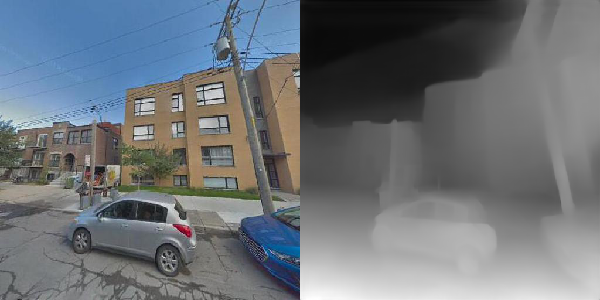

In [4]:
#display images side by side 
Image.fromarray(np.hstack((img,np.array(Image.open(depth_path).convert('RGB'))))).resize((600,300))


## Pinhole camera model

We consider a pinhole camera model. 
The mapping from 3D to 2D coordinates described by a pinhole camera is a perspective projection followed by a 180° rotation in the image plane.
Let $K_c$ the camera intrinsic matric.  
$$\mathbf{K_c} = \left[\begin{array}
{rrr}f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & A
\end{array}\right]
$$
where:  
- $f_x, f_y$ are the focal lengths along the $x$ and $y$ axis respectively ($x$ is width axis on 2D image, $y$ is height axis on 2D image, $z$ is the othogonal direction)
- $c_x, c_y$ are the pixel coordinates of the principal point on the image plane (ie point aligned with the optical axis of the camera (in our case it is the middle of the image))  

$f_x$ and $f_y$ can be computed using the horizontal and vertical field of view:  
$$ f_x = \dfrac{c_x}{\tan (FOV_x /2)}$$
$$ f_y = \dfrac{c_y}{\tan (FOV_y /2)}$$

Given a 2D point $P$ with 2D pixel coordinates in the image $(u, v)$ and depth in the camera coordinates $z$ (it can be real depth in meters, and if it is we will recover the metric informaiton, otherwise, the re will be a scale factor), the 3D location of P in the camera coordinates is : 
 $$ \left[\begin{array}
{r}x\\
y \\
z 
\end{array}\right] = K_c^{-1} \left[\begin{array}
{r}uz\\
vz \\
z 
\end{array}\right]
$$

the multiplication by z on pixel coordinates can be understood with homogeneous coordinates (explanation link : https://www.tomdalling.com/blog/modern-opengl/explaining-homogenous-coordinates-and-projective-geometry/)


If the pitch $\epsilon$ of the camera is $\neq$ 0, we can then compute the coordinates in the "real world" coordinate system (not rotated). 
$$\left[\begin{array}
{r}x'\\
y' \\
z' 
\end{array}\right]  = \left[\begin{array}
{rrr}1 & 0 & 0 \\
0 & cos(-\epsilon) & -sin(-\epsilon) \\
0 & sin(-\epsilon) & cos(-\epsilon)
\end{array}\right] \left[\begin{array}
{r}x\\
y \\
z 
\end{array}\right] $$

The depthmap image output by megadepth is actually $(1/depth)$ normalized by the max value, to get values between 0 and 1. 
For now we will use the .png image saved at the end of the process, but we might try and see how accuracy improves when we use the actual values output from the prediction model. 

In [5]:
#inverse depth map
depth_ = (1/(depth/255))
depth_ /= np.max(depth_)
depth_ *= 255

In [7]:
np.min(depth_), np.max(depth_)

(5.0, 255.0)

In [8]:
#The initial FOV in the API was 120°. But we center-cropped the image, taking out margins of 20 pixels on all sides (to get rid of the watermarks)
# We then resized the image to 512*512 so that we could apply MegaDepth on it ( some pixels are dilated)

H, W = 512, 512
init_FOVx = pi/3  #half FOV
init_FOVy = pi/3   #half FOV
FOVx = 2*atan(tan(init_FOVx)*((W/2)-20)/(W/2) )#initial FOV - angle corresponding to the crop
FOVy =  2*atan(((H/2)-20)/(H/2) * tan(init_FOVy))

cx = (W/2)
cy = (H/2)

fx = cx / tan(FOVx/2)
fy = cy/ tan(FOVy/2)

Kc = np.array([
                    [fx, 0, cx],
                    [0, fy, cy],
                    [0, 0, 1]])

In [10]:
inv_Kc = np.linalg.inv(Kc)

def my_func(a):
    return(inv_Kc.dot(a))

In [11]:
coord1, coord2 =  np.meshgrid(range(H), range(W)) 
coords_plane = np.stack((coord1.flatten(), coord2.flatten()), axis=-1)
coords3 = np.append(coords_plane,  -np.expand_dims(depth_.flatten(), axis = 1), axis = 1)
# minus sign on the third direction because the pinhole model inverses 
coords3[:, 0] = coords3[:, 0]*coords3[:, 2]
coords3[:, 1] = coords3[:, 1]*coords3[:, 2]

#get the coordinates in the camera coordinate system
coords_proj = np.apply_along_axis(my_func, 1, coords3)

In [59]:
#apply rotation matrix
epsilon = radians(10)
#this is the rotation matrix from the non rotated to rotated (camera) coordinate system
rotation = np.array([[1,0,0], [0, cos(epsilon), -sin(epsilon)], [0, sin(epsilon), cos(epsilon)]])
#we actually right apply the transpose of the rotation matrix  which is the same as left applying the matrix from camera coordinate system to real
coords_proj_ = np.dot(coords_proj, rotation)

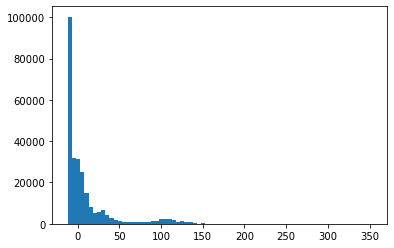

In [69]:
#get an idea of the distributionof heights 
yaxis = coords_proj_[:,1]
plt.hist(yaxis, range(int(np.floor(np.min(yaxis))), int(np.ceil(np.max(yaxis))), 5))
plt.show()

Note that the 

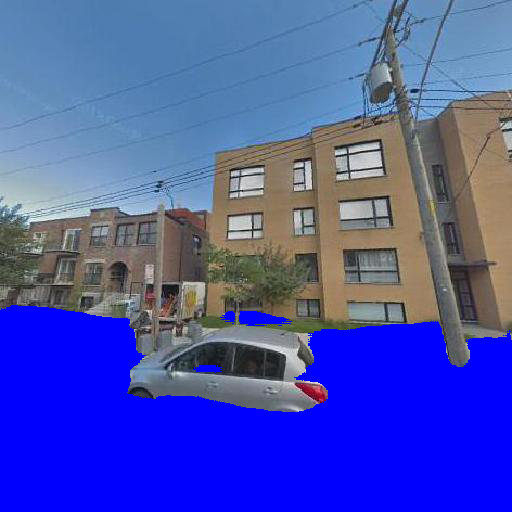

In [78]:
threshold = -8

#flood everything under threshold
flood = np.where(coords_proj_[:,1]< threshold)
colors = img.copy().reshape(512*512, 3)
colors[flood, : ] = [0,0,255]

flooded_im = colors.reshape(512,512,3)
Image.fromarray(flooded_im)

In [100]:
min_level = int(round(np.min(coords_proj_[:,1])))

In [99]:
np.linspace(min_level, -2, 0.5)

C:\Users\Mélisande\Anaconda3\envs\VRDI\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


array([], dtype=float64)

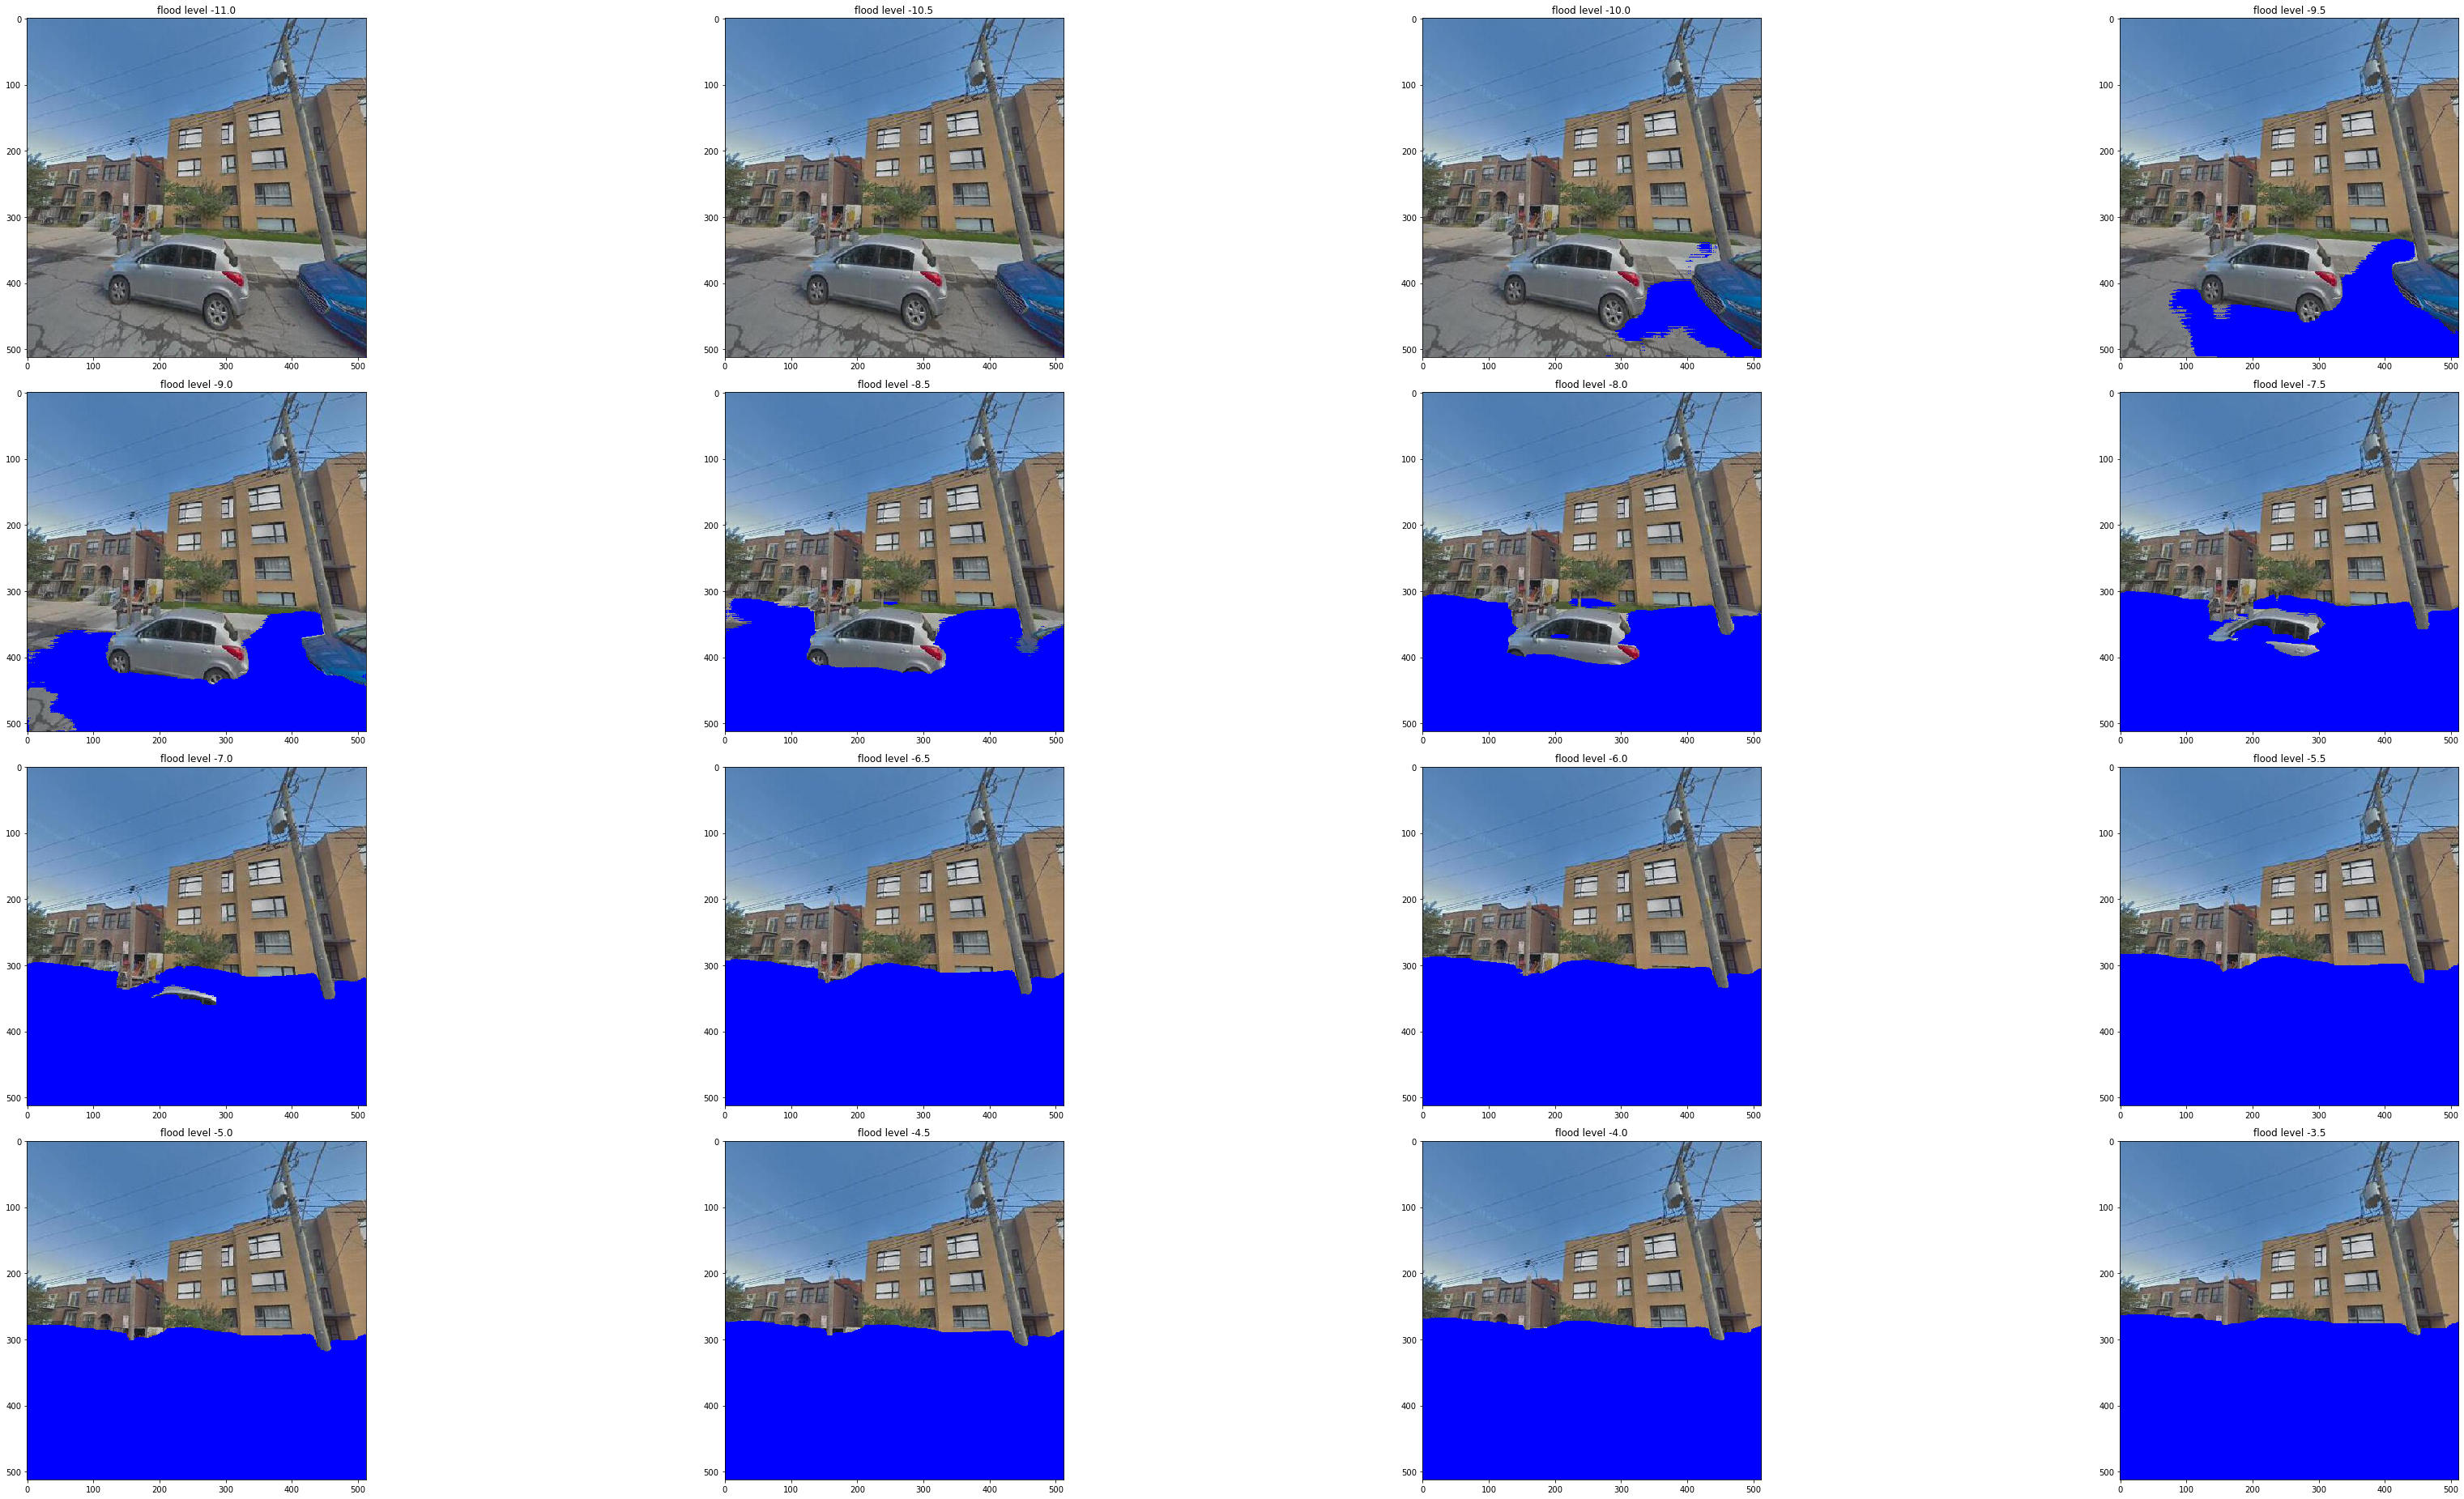

In [130]:
fig = plt.figure()
cols = 5
blue = [0,0,255]
n_images = 16
for n,thresh in enumerate(np.arange(min_level, -3, 0.5)):
    threshold = thresh
    #flood everything under threshold
    flood = np.where(coords_proj_[:,1]< threshold)
    colors = img.copy().reshape(512*512, 3)
    colors[flood, : ] = blue
    flooded_im = colors.reshape(512,512,3)
    a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
    a.set_title("flood level " + str(thresh))

    plt.imshow(flooded_im)

fig.set_size_inches(np.array(fig.get_size_inches()) *n_images/2)
fig.tight_layout()
plt.show()

## Visualize 3D point cloud 

In order to have a 3D point cloud visualization with open3D that makes sense, we need to filter out the sky. 
One possible method would be to choose a threshold of height (y axis coordinate) manually (but this won't generalize as for each image it will be different).  

Although we are only testing on a few images here, a more systematic approach would be to do semantic segmentation on the image to filter out the sky.  
Here we used a Resnet34 model from Deeplab, trained on Cityscapes, with 19 classes. (https://github.com/cc-ai/floods-gans/tree/master/ground_segmentation adapted to get outputs of the classes from the segmentation. 
The sky corresponds to class 10.
                                                                                           

In [117]:
coords3D = np.array((900,1200, 3))

img_flatten = img.reshape(H*W, 3)

In [118]:
#segment out the sky- the projection of the sky will not make sense and impact the normalization. 
segmentation = np.load('./data/milacropresize_segment.npy')

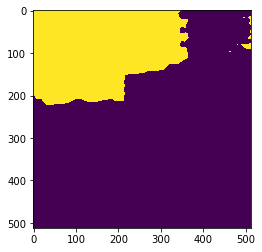

In [120]:
mask = Image.fromarray((segmentation==10).astype(int)*255).convert('1')
plt.imshow(mask)

In [140]:
interest = coords_proj_[(segmentation!=10).flatten()]
interest[:, 0] = -interest[:, 0]

#minus because otherwise we get reverse
colors_pt = img[np.where(segmentation !=10)].astype(int)/255

In [144]:
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(interest)
pcd.colors = open3d.utility.Vector3dVector(colors_pt)
open3d.io.write_point_cloud("../mila_test.ply", pcd)

True

In [145]:
pcd = open3d.io.read_point_cloud("../mila_test.ply")
open3d.visualization.draw_geometries([pcd])

In [143]:

#visualize flood
threshold = -8
colors_pt_ = colors_pt.copy()
colors_pt_[(interest[:,1] < threshold), :] = blue
pcd.colors = open3d.utility.Vector3dVector(colors_pt_)
open3d.visualization.draw_geometries([pcd])